In [142]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import elasticsearch
import os
pd.options.plotting.backend = "plotly"

In [143]:
avg_over_min = 1
days_look_back = 20

In [144]:
en_date = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
st_date = (datetime.now() - timedelta(days=days_look_back)).strftime('%Y-%m-%dT%H:%M:%S')

en_date_dt = datetime.now().astimezone(pytz.timezone('America/New_York'))
st_date_dt = (datetime.now() - timedelta(days=days_look_back)).astimezone(pytz.timezone('America/New_York'))

st_date_utc = datetime.strptime(st_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
en_date_utc = datetime.strptime(en_date, '%Y-%m-%dT%H:%M:%S').astimezone(pytz.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')

In [145]:
print(st_date_utc)
print(en_date_utc)

2022-03-23T14:47:37Z
2022-04-12T14:47:37Z


In [146]:
# Import and format Praxis data
uri = 'https://aws.southcoastscience.com/topicMessages?topic=nyu/brooklyn/loc/3/particulates&' \
'startTime=%s&endTime=%s&checkpoint=**:/%i:00' \
% (st_date_utc, en_date_utc, avg_over_min)
print(uri)
praxis_df = pd.DataFrame([])

while uri != '':
    header = {"authorization": "api-key nyu-brooklyn"}
    response = requests.get(uri, headers=header)
    json = response.json()

    data = {}

    data['ts'] = pd.to_datetime([ele['rec'] for ele in json['Items']]).tz_convert(tz='US/Eastern')

    data['praxis_pm1_vals'] = [ele['val']['pm1'] for ele in json['Items']]
    data['praxis_pm2p5_vals'] = [ele['val']['pm2p5'] for ele in json['Items']]
    data['praxis_pm10_vals'] = [ele['val']['pm10'] for ele in json['Items']]

    data['praxis_pm1_vals_adj'] = [ele['exg']['rn20']['pm1'] for ele in json['Items']]
    data['praxis_pm2p5_vals_adj'] = [ele['exg']['rn20']['pm2p5'] for ele in json['Items']]
    data['praxis_pm10_vals_adj'] = [ele['exg']['rn20']['pm10'] for ele in json['Items']]

#     praxis_df = pd.DataFrame(data).set_index('ts').resample(avg_over).mean()

    if 'next' in json:
        uri = json['next']
    else:
        uri = ''
    praxis_df = pd.concat([praxis_df, pd.DataFrame(data)])
    
    time.sleep(0.5)
praxis_df = praxis_df.set_index('ts').resample('%iT' % avg_over_min).mean()
praxis_df = praxis_df.loc[st_date_dt:en_date_dt]

https://aws.southcoastscience.com/topicMessages?topic=nyu/brooklyn/loc/3/particulates&startTime=2022-03-23T14:47:37Z&endTime=2022-04-12T14:47:37Z&checkpoint=**:/1:00


In [147]:
praxis_df

praxis_pm1_vals  praxis_pm2p5_vals  \
ts                                                              
2022-03-23 10:48:00-04:00              0.5                1.1   
2022-03-23 10:49:00-04:00              0.4                1.1   
2022-03-23 10:50:00-04:00              0.4                1.0   
2022-03-23 10:51:00-04:00              0.4                0.8   
2022-03-23 10:52:00-04:00              0.4                1.1   
...                                    ...                ...   
2022-04-12 10:43:00-04:00              2.4                5.5   
2022-04-12 10:44:00-04:00              2.3                4.8   
2022-04-12 10:45:00-04:00              2.4                4.9   
2022-04-12 10:46:00-04:00              2.2                5.3   
2022-04-12 10:47:00-04:00              2.6                5.6   

                           praxis_pm10_vals  praxis_pm1_vals_adj  \
ts                                                                 
2022-03-23 10:48:00-04:00               5.5                  1.5   
2022-03-23 10:49:00-04:00               2.8                  1.2   
2022-03-23 10:50:00-04:00               5.0                  1.8   
2022-03-23 10:51:00-04:00               6.0                  1.0   
2022-03-23 10:52:00-04:00               3.2                  1.1   
...                                     ...                  ...   
2022-04-12 10:43:00-04:00              18.0                  5.0   
2022-04-12 10:44:00-04:00              11.9                  5.3   
2022-04-12 10:45:00-04:00              17.0                  4.5   
2022-04-12 10:46:00-04:00              13.2                  4.8   
2022-04-12 10:47:00-04:00              11.1                  5.6   

                           praxis_pm2p5_vals_adj  praxis_pm10_vals_adj  
ts                                                                      
2022-03-23 10:48:00-04:00                    1.9                   6.9  
2022-03-23 10:49:00-04:00                    2.0                   6.2  
2022-03-23 10:50:00-04:00                    2.6                   8.9  
2022-03-23 10:51:00-04:00                    1.7                  12.6  
2022-03-23 10:52:00-04:00                    2.0                   7.2  
...                                          ...                   ...  
2022-04-12 10:43:00-04:00                    5.6                  11.9  
2022-04-12 10:44:00-04:00                    5.8                  12.1  
2022-04-12 10:45:00-04:00                    5.1                  11.4  
2022-04-12 10:46:00-04:00                    6.4                  12.8  
2022-04-12 10:47:00-04:00                    6.8                  13.8  

[28800 rows x 6 columns]

In [148]:
st_time ="2022-03-29 10:55:00-04:00"
praxis_df2 = praxis_df.loc['2022-03-19 14:48:00-04:00':'2022-03-29 10:55:00-04:00']
praxis_df2

praxis_pm1_vals  praxis_pm2p5_vals  \
ts                                                              
2022-03-23 10:48:00-04:00              0.5                1.1   
2022-03-23 10:49:00-04:00              0.4                1.1   
2022-03-23 10:50:00-04:00              0.4                1.0   
2022-03-23 10:51:00-04:00              0.4                0.8   
2022-03-23 10:52:00-04:00              0.4                1.1   
...                                    ...                ...   
2022-03-29 10:51:00-04:00              4.6                5.8   
2022-03-29 10:52:00-04:00              6.0                7.4   
2022-03-29 10:53:00-04:00              0.9                1.8   
2022-03-29 10:54:00-04:00              1.1                2.0   
2022-03-29 10:55:00-04:00              0.9                2.0   

                           praxis_pm10_vals  praxis_pm1_vals_adj  \
ts                                                                 
2022-03-23 10:48:00-04:00               5.5                  1.5   
2022-03-23 10:49:00-04:00               2.8                  1.2   
2022-03-23 10:50:00-04:00               5.0                  1.8   
2022-03-23 10:51:00-04:00               6.0                  1.0   
2022-03-23 10:52:00-04:00               3.2                  1.1   
...                                     ...                  ...   
2022-03-29 10:51:00-04:00               8.3                 14.3   
2022-03-29 10:52:00-04:00              12.9                 28.6   
2022-03-29 10:53:00-04:00              14.0                  3.4   
2022-03-29 10:54:00-04:00               5.6                  3.4   
2022-03-29 10:55:00-04:00               6.8                  2.0   

                           praxis_pm2p5_vals_adj  praxis_pm10_vals_adj  
ts                                                                      
2022-03-23 10:48:00-04:00                    1.9                   6.9  
2022-03-23 10:49:00-04:00                    2.0                   6.2  
2022-03-23 10:50:00-04:00                    2.6                   8.9  
2022-03-23 10:51:00-04:00                    1.7                  12.6  
2022-03-23 10:52:00-04:00                    2.0                   7.2  
...                                          ...                   ...  
2022-03-29 10:51:00-04:00                   15.8                  21.6  
2022-03-29 10:52:00-04:00                   29.1                  46.6  
2022-03-29 10:53:00-04:00                    5.2                  30.1  
2022-03-29 10:54:00-04:00                    5.2                  15.6  
2022-03-29 10:55:00-04:00                    3.5                  14.0  

[8648 rows x 6 columns]

In [149]:
# Import and format Piera Canary data
# 168
canary_df = pd.DataFrame([])

for x in range(840):
    uri = 'https://sensei.pierasystems.com/api/get-minute-averages/318?page=%i' % x
    response = requests.get(uri)
    json = response.json()
    data = {}
    if json["data"] == "":
        break
    data['ts'] = pd.to_datetime([ele['time'] for ele in json['data']]).tz_convert(tz='US/Eastern')
    
    data['canary_pm1_vals'] = [ele['pm10'] for ele in json['data']]
    data['canary_pm2p5_vals'] = [ele['pm25'] for ele in json['data']]
    data['canary_pm10_vals'] = [ele['pm100'] for ele in json['data']]
    data['canary_temp'] = [ele['temp'] for ele in json['data']]
    data['canary_rh'] = [ele['rh'] for ele in json['data']]
    
    canary_df = pd.concat([canary_df, pd.DataFrame(data)])

    if canary_df['ts'].iloc[-1] < pd.DatetimeIndex([st_date_dt]):
        break
    time.sleep(0.5)
    
canary_df = canary_df.set_index('ts').resample('%iT' % avg_over_min).mean()
canary_df = canary_df.loc[st_date_dt:en_date_dt]

In [150]:
print(st_date_dt)

2022-03-23 10:47:37.851986-04:00


In [151]:
canary_df


canary_pm1_vals  canary_pm2p5_vals  \
ts                                                              
2022-03-23 10:48:00-04:00         0.170958           0.210138   
2022-03-23 10:49:00-04:00         0.173423           0.251783   
2022-03-23 10:50:00-04:00         0.211756           0.329296   
2022-03-23 10:51:00-04:00         0.165128           0.282668   
2022-03-23 10:52:00-04:00         0.139600           0.217960   
...                                    ...                ...   
2022-03-29 10:51:00-04:00        44.171700          61.567600   
2022-03-29 10:52:00-04:00        48.791900          76.113500   
2022-03-29 10:53:00-04:00         8.878470           9.400870   
2022-03-29 10:54:00-04:00         2.762430           3.180350   
2022-03-29 10:55:00-04:00         0.850995           1.007710   

                           canary_pm10_vals  canary_temp  canary_rh  
ts                                                                   
2022-03-23 10:48:00-04:00          0.210138          7.1       31.0  
2022-03-23 10:49:00-04:00          0.251783          7.0       31.0  
2022-03-23 10:50:00-04:00          0.329296          6.3       32.2  
2022-03-23 10:51:00-04:00          0.282668          6.6       31.6  
2022-03-23 10:52:00-04:00          0.217960          6.4       32.3  
...                                     ...          ...        ...  
2022-03-29 10:51:00-04:00         62.194000          3.9       31.2  
2022-03-29 10:52:00-04:00         76.322300          4.0       30.9  
2022-03-29 10:53:00-04:00          9.400870          3.9       30.8  
2022-03-29 10:54:00-04:00          3.284750          3.8       30.9  
2022-03-29 10:55:00-04:00          1.007710          3.4       32.3  

[8648 rows x 5 columns]

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



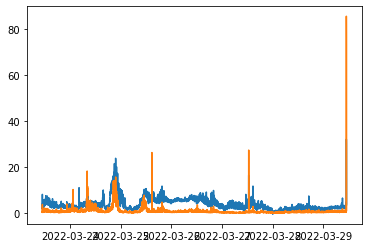

In [152]:

import matplotlib.pyplot as plt
%matplotlib inline

P =plt.plot(praxis_df2.index,praxis_df2["praxis_pm2p5_vals_adj"]) ##BLUE
P =plt.plot(canary_df.index,canary_df["canary_pm2p5_vals"])

In [153]:
uri = 'https://api.thingspeak.com/channels/1530870/feeds.json?api_key=U4IJYTKQ1ON601M3&average=%i&days=%i' \
% (avg_over_min, days_look_back)
print(uri)
response = requests.get(uri)
json = response.json()
data = {}
data['ts'] = pd.to_datetime([ele['created_at'] for ele in json['feeds']]).tz_convert(tz='US/Eastern')
    
data['purple_pm1_vals'] = [ele['field1'] for ele in json['feeds']]
data['purple_pm2p5_vals'] = [ele['field2'] for ele in json['feeds']]
data['purple_pm10_vals'] = [ele['field3'] for ele in json['feeds']]

purple_df = pd.DataFrame(data)
    
# purple_df = purple_df.set_index('ts').resample('%iT' % avg_over_min).mean().interpolate(method='pad', limit=2)
purple_df = purple_df.set_index('ts').resample('%iT' % avg_over_min).mean()
purple_df = purple_df.loc[st_date_dt:en_date_dt]

https://api.thingspeak.com/channels/1530870/feeds.json?api_key=U4IJYTKQ1ON601M3&average=1&days=20


In [154]:
purple_df

purple_pm1_vals  purple_pm2p5_vals  \
ts                                                              
2022-04-01 06:02:00-04:00             1.28               3.72   
2022-04-01 06:03:00-04:00              NaN                NaN   
2022-04-01 06:04:00-04:00             1.00               3.09   
2022-04-01 06:05:00-04:00              NaN                NaN   
2022-04-01 06:06:00-04:00             1.63               4.35   
...                                    ...                ...   
2022-04-12 10:43:00-04:00              NaN                NaN   
2022-04-12 10:44:00-04:00             5.74              10.51   
2022-04-12 10:45:00-04:00              NaN                NaN   
2022-04-12 10:46:00-04:00             5.18              10.44   
2022-04-12 10:47:00-04:00              NaN                NaN   

                           purple_pm10_vals  
ts                                           
2022-04-01 06:02:00-04:00              4.21  
2022-04-01 06:03:00-04:00               NaN  
2022-04-01 06:04:00-04:00              3.09  
2022-04-01 06:05:00-04:00               NaN  
2022-04-01 06:06:00-04:00              4.37  
...                                     ...  
2022-04-12 10:43:00-04:00               NaN  
2022-04-12 10:44:00-04:00             12.87  
2022-04-12 10:45:00-04:00               NaN  
2022-04-12 10:46:00-04:00             11.87  
2022-04-12 10:47:00-04:00               NaN  

[16126 rows x 3 columns]

In [155]:
comb_df = canary_df.join(praxis_df)
comb_df = comb_df.join(purple_df)

In [156]:
GROUP = time.time()

def scroll(es, index, body, scroll='2m', size=1000, timeout=25, **kw):
    if isinstance(timeout, int):
        timeout = '{}s'.format(int(timeout))
    page = es.search(index=index, body=body, scroll=scroll, size=size, timeout=timeout, **kw)
    scroll_id, hits = page['_scroll_id'], page['hits']['hits']
    while len(hits):
        yield hits
        page = es.scroll(scroll_id=scroll_id, scroll=scroll)
        scroll_id, hits = page['_scroll_id'], page['hits']['hits']
        
def sensor_query(key=None, nodeid=None, start=None, end=None, k_time="time", group=GROUP):
    match = []
    if key and nodeid:
        match.append({"term": {f'{key}.keyword': nodeid}})
    end = end or 'now'
    if start:
        match.append({"range" : {k_time : {"gte" : start, "lte" : end}}})
    elif end:
        match.append({"range" : {k_time : {"lte" : end}}})
    return { "query": { "bool": {"must": match} } } if match else {}

def download_sensor_data(table, key=None, nodeid=None, start=None, end=None, save=True, k_time='time', **kw):
    query = sensor_query(key, nodeid, start, end, k_time=k_time, **kw)
    print(query)
    
    def pull():
        with tqdm(scroll(es, table, query)) as pbar:
            for i, hits in enumerate(pbar):
                hits = [h['_source'] for h in hits]
                times = [h[k_time] for h in hits]
                pbar.write('{}. n hits: {}. {} - {}'.format(i, len(hits), min(times), max(times)))
                for h in hits:
                    yield h
    if not save:
        return list(pull())

    fname = 'data/{}/{}.json'.format(group, nodeid or table)
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    print(f'Pulling node={nodeid} for ({start} -> {end}) ... saving to {fname}')
    with open(fname, 'w') as f:
        for h in pull():
            f.write(json.dumps(h) + '\n')
    print('all done!')
    return fname

In [157]:
# ss[0]['aq']

In [158]:
# fig = comb_df[['canary_pm2p5_vals', 'praxis_pm2p5_vals_adj', 'praxis_pm2p5_vals', 'purple_pm2p5_vals', 'piera7100_pm2p5_vals']].plot();
fig = comb_df[['canary_pm2p5_vals', 'praxis_pm2p5_vals_adj', 'praxis_pm2p5_vals', 'purple_pm2p5_vals']].plot();
fig.show()

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
df = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': canary_df["canary_pm2p5_vals"], 'Temp': canary_df["canary_temp"], 'RelHum': canary_df["canary_rh"]})

X = df[['Sensor_O1','Temp', 'RelHum']]
Y = df['RefSt']
X= X.fillna(X.mean())
Y=Y.fillna(Y.mean())



In [192]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.44, random_state = 1, shuffle = False)

ee = OneClassSVM(nu=0.67)
yhat = ee.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, Y_train = X_train[mask], Y_train[mask]


df_train = pd.DataFrame({'RefSt': Y_train, 'Sensor_O1': X_train["Sensor_O1"],'Temp': X_train["Temp"], 'RelHum': X_train["RelHum"]})
df_test = pd.DataFrame({'RefSt': Y_test, 'Sensor_O1': X_test["Sensor_O1"],'Temp': X_test["Temp"], 'RelHum': X_test["RelHum"]})



In [193]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def loss_functions(y_true, y_pred):
    print("Loss functions:")
    print("* R-squared =", r2_score(y_true, y_pred))
    print("* RMSE =", mean_squared_error(y_true, y_pred))
    print("* MAE =", mean_absolute_error(y_true, y_pred))


# %%
# Normalise sensor data
def normalize(col):
    μ = col.mean()
    sig = col.std()
    return (col - μ)/sig

df["normRefSt"] = normalize(df["RefSt"])
df["normSensor_O3"] = normalize(df["Sensor_O1"])
df["normTemp"] = normalize(df["Temp"])
df["normRelHum"] = normalize(df["RelHum"])


In [194]:
Sensor_O3_RefSt_factor = df[["Sensor_O1", "RefSt"]]
#Sensor_O3_RefSt_factor["RefSt"] = Sensor_O3_RefSt_factor["RefSt"]
Sensor_O3_RefSt_factor.plot()

In [195]:
X_train, Y_train;

Intercept: 
 5.2682106898303065
Coefficients: 
 [ 0.64479643  0.31374443 -0.07114632]
0.8074264960362483
Loss functions:
* R-squared = -0.9416236637281985
* RMSE = 3.59165784896453
* MAE = 1.2852576996196245


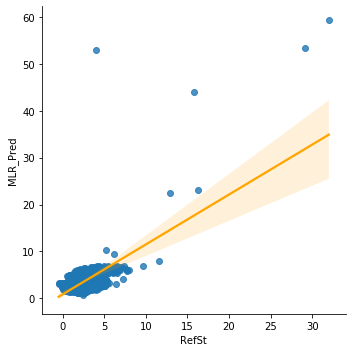

In [199]:
from sklearn.linear_model import LinearRegression

import seaborn as sns
# Model
lr = LinearRegression()


# Fit
lr.fit(X_train, Y_train)

# Get MLR coefficients
print('Intercept: \n', lr.intercept_)
print('Coefficients: \n', lr.coef_)

# Predict
df_test["MLR_Pred"] = lr.intercept_ + lr.coef_[0]*df_test["Sensor_O1"] + lr.coef_[1]*df_test["Temp"] + lr.coef_[2]*df_test["RelHum"]

# Plot linear
df_test[["RefSt", "MLR_Pred"]].plot()
print(lr.score(X_train, Y_train))


# Plot regression
sns.lmplot(x = 'RefSt', y = 'MLR_Pred', data = df_test, fit_reg = True, line_kws = {'color': 'orange'}) 

# Loss
loss_functions(y_true = df_test["RefSt"], y_pred = df_test["MLR_Pred"])

In [197]:
# plt.plot(praxis_df2.index,praxis_df2["praxis_pm2p5_vals_adj"]) ##BLUE
# plt.plot(df_test["MLR_Pred"] )
# canary_df.index,canary_df["canary_pm2p5_vals"]##BLUE

df2 = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': df_test["MLR_Pred"]})
Sensor_O3_RefSt = df2[["Sensor_O1", "RefSt"]]
Sensor_O3_RefSt.plot()

In [198]:
# df_final = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': canary_df["canary_pm2p5_vals"]})
df["MLR_Pred"] = lr.intercept_ + lr.coef_[0]*df["Sensor_O1"] + lr.coef_[1]*df["Temp"] + lr.coef_[2]*df["RelHum"]
df = pd.DataFrame({'RefSt': praxis_df2["praxis_pm2p5_vals_adj"], 'Sensor_O1': df["MLR_Pred"]})
Sensor_O3_ = df_final[["Sensor_O1", "RefSt"]]
Sensor_O3_.plot()